# SatData Multi-Area DEM Download (COP30DEM)

Example for downloading Copernicus DEM 30m for multiple areas.

DEM is static elevation data - same across all time periods.

Author: Peter Kongstad

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box, Point

from sat_data_acquisition import SatDataClient, ProcessingParams, SaveParams, configure_logging
from sat_data_acquisition.processing import save_data
from sat_data_acquisition.config.settings import SatDataSettings

In [3]:
# Configure logging
configure_logging(verbose=False)

## Multiple Areas from GeoJSON

Download DEM for multiple areas defined in a GeoJSON file.

In [4]:
# Load GeoJSON with multiple areas
gdf = gpd.read_file('../../data/geojson/example_areas.geojson')

print(f"[OK] Loaded {len(gdf)} areas")
print(gdf[['name', 'description']])

[OK] Loaded 3 areas
         name                           description
0  copenhagen     Copenhagen, Denmark - City Center
1      london  London, United Kingdom - Westminster
2     seattle               Seattle, USA - Downtown


In [5]:
# Initialize client and configure processing parameters
client = SatDataClient()
settings = SatDataSettings()

processing_params = ProcessingParams(
    satellite='CopDEM30MPC',
    search_method='geometry',
    bands=['data'],
    clip_method='geometry'
)
# Note: No dates or cloud_coverage for DEM!

print("[OK] Configured")

[OK] Configured


In [6]:
# Configure save parameters
save_params = SaveParams(
    output_path='../../data',
    save_to_local=True,
    save_as_geotiff=True,
)

# Process each area
results = []
datasets = {}

for idx, row in gdf.iterrows():
    area_name = row['name']
    geometry = row.geometry
    
    try:
        dataset = client.search_and_create_image(
            geometry=geometry,
            processing_params=processing_params,
            area_name=area_name,
        )
        
        # Save to disk (if dataset has time dimension)
        if 'time' in dataset.dims and len(dataset.time) > 0:
            image_slice = dataset.sel(time=dataset.time.values[0])
            date_str = str(dataset.time.values[0])[:10]
            
            save_data(
                image=image_slice,
                identifier=area_name.lower(),
                datetime=date_str,
                satellite=processing_params.satellite,
                provider='MPC',
                save_params=save_params,
                band="elevation",
            )
        
        # Store for visualization
        datasets[area_name] = dataset
        
        # Get elevation statistics
        if 'time' in dataset.dims and len(dataset.time) > 0:
            elev = dataset.sel(time=dataset.time.values[0])['data'].values
        else:
            elev = dataset['data'].values
        
        results.append({
            'area': area_name,
            'min_elev': float(np.nanmin(elev)),
            'max_elev': float(np.nanmax(elev)),
            'mean_elev': float(np.nanmean(elev)),
            'status': 'success'
        })
        
        print(f"[OK] {area_name}: {np.nanmin(elev):.1f}m to {np.nanmax(elev):.1f}m")
        
    except Exception as e:
        print(f"[ERROR] {area_name}: {e}")
        results.append({
            'area': area_name,
            'min_elev': None,
            'max_elev': None,
            'mean_elev': None,
            'status': 'error',
            'error': str(e)
        })

[OK] copenhagen: -16.5m to 33.1m
[OK] london: -5.1m to 61.3m
[OK] seattle: -3.1m to 141.6m


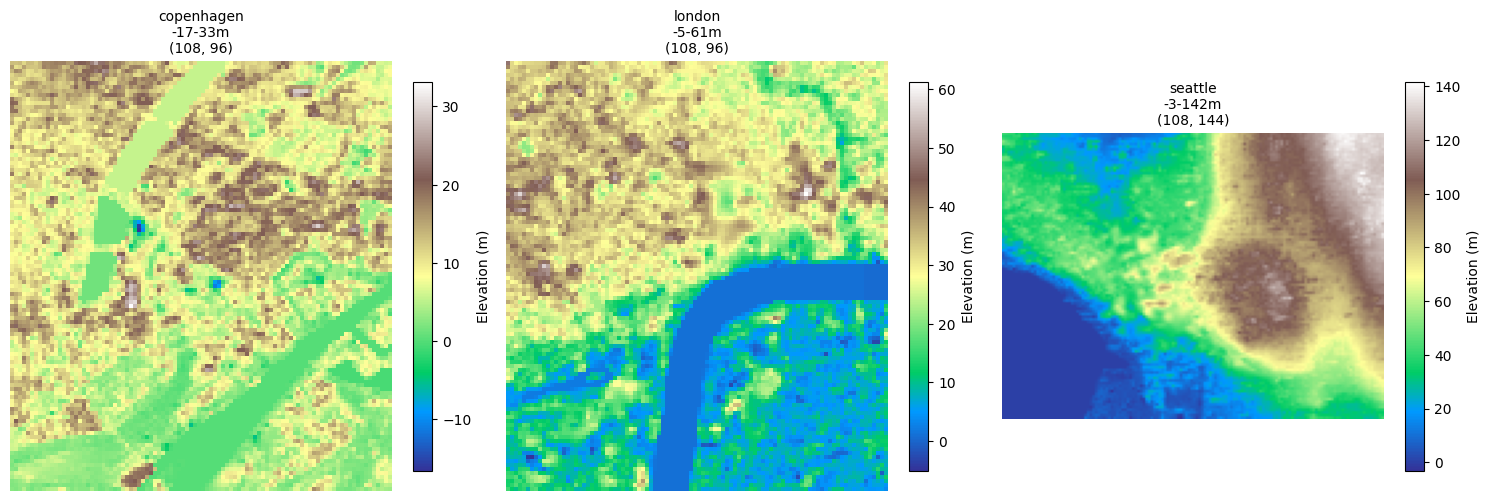

In [7]:
# Visualize DEMs for each area (max 3 areas)
if len(datasets) > 0:
    n_areas = min(len(datasets), 3)
    
    fig, axes = plt.subplots(1, n_areas, figsize=(15, 5))
    if n_areas == 1:
        axes = [axes]
    
    for idx, (area_name, dataset) in enumerate(list(datasets.items())[:n_areas]):
        ax = axes[idx]
        
        # Extract elevation
        if 'time' in dataset.dims and len(dataset.time) > 0:
            elevation = dataset.sel(time=dataset.time.values[0])['data'].values
        else:
            elevation = dataset['data'].values
        
        # Plot with relative color scale per location and correct aspect ratio
        im = ax.imshow(elevation, cmap='terrain', aspect='equal')
        ax.set_title(f"{area_name}\n{np.nanmin(elevation):.0f}-{np.nanmax(elevation):.0f}m\n{elevation.shape}", 
                    fontsize=10)
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, label='Elevation (m)')
    
    plt.tight_layout()
    plt.show()

In [8]:
# Summary
import pandas as pd
df = pd.DataFrame(results)
print("\nElevation Summary:")
print(df.round(1))


Elevation Summary:
         area  min_elev  max_elev  mean_elev   status
0  copenhagen     -16.5      33.1        8.6  success
1      london      -5.1      61.3       20.1  success
2     seattle      -3.1     141.6       54.2  success


## Advanced DEM Analysis

### Calculate Slope
```python
def calculate_slope(elevation, pixel_size=30):
    """Calculate slope in degrees from elevation."""
    dy, dx = np.gradient(elevation, pixel_size)
    slope = np.arctan(np.sqrt(dx**2 + dy**2))
    return np.degrees(slope)

slope = calculate_slope(elevation)
```

### Calculate Aspect
```python
def calculate_aspect(elevation):
    """Calculate aspect (direction of slope) in degrees."""
    dy, dx = np.gradient(elevation)
    aspect = np.arctan2(-dx, dy)
    return np.degrees(aspect) % 360

aspect = calculate_aspect(elevation)
```

### Applications
- **Watershed analysis**: Flow direction, accumulation
- **Solar analysis**: Combined with aspect for solar potential
- **Erosion modeling**: Slope and flow path analysis
- **3D terrain models**: Combine with optical imagery
- **Flood risk**: Low-lying area identification